<h1>SCRAPPING INDEED</h1>

In [183]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import numpy as np

<h1>Scrapping Company information:</h1>
    

In [200]:
def get_company_info(company_name):
    '''
    input : company name
    process : 
        - scrape data from indeed on the company
        - employees reviews
    output : pd df combining the values extracted
    '''
    
     
    #we create a fake_user to reduce the chances of getting blocked 
    from fake_useragent import UserAgent
    def random_user_agent():
        ua = UserAgent()
        return(ua.random)
    random_user = random_user_agent()
    query = str()
    header = {'User-Agent':random_user}
    
    #we extract the data from the url and call the get_job_data function for the first page 
    url = 'https://www.indeed.com/cmp/'+company_name
    response = requests.get(url, headers = header)
    soup = BeautifulSoup(response.content, 'lxml') 
    
    #create the output dataframe 
    values = [company_name, response.status_code == 200]
    
    
    #find the reviews on quality of job
    # 'Work/Life Balance %','Compensation/Benefits %', 
    #'Job Security/Advancement %','Management %', 'Culture %'
    try: 
        review = soup.find(class_="cmp-ReviewAndRatingsStory-rating")
        for div in review.find_all(class_ = "cmp-RatingCategory-rating"):
            values += [float(div.text)/5*100]   
    except: 
        values += [np.NaN]*5
     
        
    #we try to find the % of employees that approve of CEO’s performance
    #'perc_approval_CEO %' 
    try:
        values += [int(soup.find(class_='cmp-CeoWidgetWithRating-percent').text[:-1])]
    except: 
        values += [np.NaN]
        
    
    
    #find the quality of work environement 
    #'Slow-paced / Quick-paced %','Stressful / Relaxed %',
    #'Competitive / Collaborative %'
    try:  
        review = soup.find(class_='cmp-WorkCultureStory-sliderBar').find_all(class_="cmp-SliderBar-indicator")
        for val in review:
            values += [float(str(val['style']).split(');')[0][-10:])*100]
    except:
        values += [np.NaN]*3
    
    
    
    #we want to find the statistics of the review
    try:
        url = 'https://www.indeed.com/cmp/'+company_name+'/reviews'
        response = requests.get(url, headers = header)
        soup = BeautifulSoup(response.content, 'lxml') 
        review = soup.find(class_ = 'cmp-sidebar-section cmp-bordered-box')
        
        
        values += [float(review.find(class_="cmp-average-rating").text)/5*100]
        n_review = int(review.find(class_ = 'cmp-note').text[len('Based on '):-len(' reviews')].replace(',',''))
        values  += [n_review]
    
        for val in review.find_all(class_ ='cmp-ReviewHistogram-number'):
            values += [float(val.text.replace('K',''))* (1 + 999*('K' in val.text))/n_review*100]

    except:
        values+= [np.NaN]*7
        
    col = ['Company_Name','On_Indeed', 
           'Work/Life Balance %','Compensation/Benefits %',
           'Job Security/Advancement %','Management %',
            'Culture %','perc_approval_CEO %',
            'Slow-paced / Quick-paced %','Stressful / Relaxed %',
            'Competitive / Collaborative %',
            'overall rating %','total number of reviews',
            '5 rating %','4 rating %','3 rating %','2 rating %','1 rating %']
    df = pd.DataFrame(columns = col)
    df.loc[0] = values
        
    return df
    
company_name='datadog'
df = get_company_info(company_name)
df   

,Company_Name,On_Indeed,Work/Life Balance %,Compensation/Benefits %,Job Security/Advancement %,Management %,Culture %,perc_approval_CEO %,Slow-paced / Quick-paced %,Stressful / Relaxed %,Competitive / Collaborative %,overall rating %,total number of reviews,5 rating %,4 rating %,3 rating %,2 rating %,1 rating %
0,datadog,True,62.0,62.0,56.0,50.0,68.0,NaN,NaN,NaN,NaN,70.0,11,27.272727,27.272727,18.181818,18.181818,9.090909


Combine this function for a list of company

In [203]:
def get_company_info_list(company_names):
    '''
    input : list of companies name
    output : pd df of indeed review data 
    '''
    
    df  = get_company_info('just to create a data frame')
    #searching for the data from each company and compiling the dataframe 
    for company_name in company_names:
        #message to see the progression of the data collection
        print ('getting company data from Indeed for ',company_name)
        df = df.append(get_company_info(company_name),ignore_index=True)
    df.index = df['Company_Name']
    df = df.drop('just to create a data frame',axis = 0)
    return df

company_names = ['datadog','facebook','google','louis vuitton','amazon','bcg']
df = get_company_info_list(company_names)
df


getting company data from Indeed for  datadog
getting company data from Indeed for  facebook
getting company data from Indeed for  google
getting company data from Indeed for  louis vuitton
getting company data from Indeed for  amazon
getting company data from Indeed for  bcg


,Company_Name,On_Indeed,Work/Life Balance %,Compensation/Benefits %,Job Security/Advancement %,Management %,Culture %,perc_approval_CEO %,Slow-paced / Quick-paced %,Stressful / Relaxed %,Competitive / Collaborative %,overall rating %,total number of reviews,5 rating %,4 rating %,3 rating %,2 rating %,1 rating %
Company_Name,,,,,,,,,,,,,,,,,,
datadog,datadog,True,62.0,62.0,56.0,50.0,68.0,NaN,NaN,NaN,NaN,70.0,11,27.272727,27.272727,18.181818,18.181818,9.090909
facebook,facebook,True,80.0,80.0,70.0,72.0,82.0,85,95.522386,54.123710,55.744684,84.0,488,50.819672,29.508197,12.909836,4.098361,2.663934
google,google,True,84.0,80.0,72.0,78.0,84.0,88,92.891450,70.567060,57.001170,86.0,3192,56.390977,27.318296,11.998747,2.882206,2.005013
louis vuitton,louis vuitton,True,70.0,74.0,70.0,70.0,76.0,76,94.444440,17.699115,32.679740,78.0,563,39.076377,33.570160,13.499112,6.039076,7.815275
amazon,amazon,True,66.0,74.0,64.0,64.0,68.0,73,97.169620,23.672119,34.165020,72.0,38321,30.009655,28.182981,22.963910,9.394327,9.655280
bcg,bcg,True,70.0,84.0,76.0,78.0,84.0,92,97.058820,21.739130,56.701030,84.0,246,51.219512,30.081301,11.382114,3.252033,4.065041


<h2>Visualisation: % of data available</h2>

Text(0.5, 1.0, 'Data available in % from Indeed')

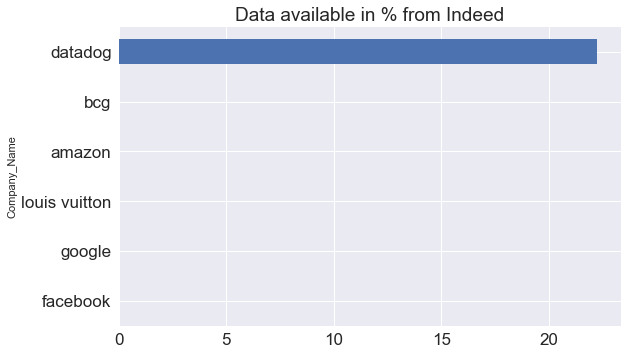

In [204]:
df_drop = df.drop(['Company_Name','On_Indeed'],axis=1)
df_drop['Present_data %'] = (df.isna().mean(axis = 1)*100)
df_drop['Present_data %'].sort_values(ascending=True).plot(kind = 'barh',fontsize=17,figsize=(9,5.5))
plt.title('Data available in % from Indeed',fontsize=19)

<h2>Visualisation: Ranking of the 4 worst/best companies regarding several criterias</h2>

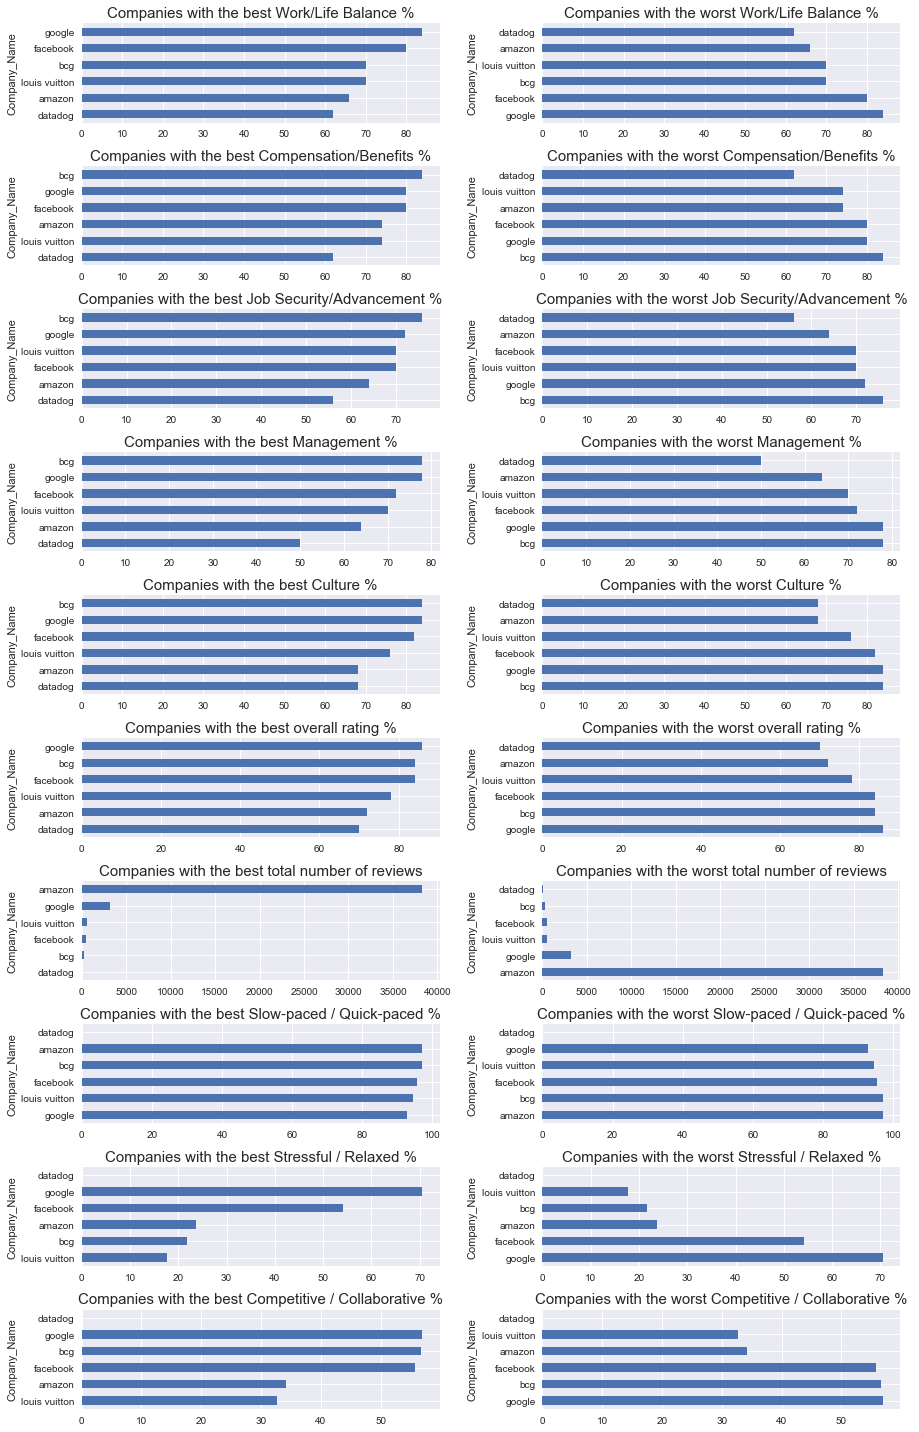

In [205]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

COL_NUM = 2
ROW_NUM = 3

col = ['Work/Life Balance %','Compensation/Benefits %','Job Security/Advancement %','Management %','Culture %','overall rating %','total number of reviews','Slow-paced / Quick-paced %','Stressful / Relaxed %','Competitive / Collaborative %']

COL_NUM = 2
ROW_NUM = len(col)
fig, axes = plt.subplots(ROW_NUM, COL_NUM)

for i in range(0,len(col)):

    c = col[i]
    ax=axes[i,0]
    value = df[c].sort_values(ascending=True)
    value.plot(kind='barh', fontsize=10,figsize=(13,20),ax=ax)
    ax.set_title('Companies with the best '+c,fontsize=15)

    ax=axes[i,1]
    value = df[c].sort_values(ascending=False)
    value.plot(kind='barh', fontsize=10,figsize=(13,20),ax=ax)
    ax.set_title('Companies with the worst '+c,fontsize=15)

plt.tight_layout()